---
# Projet MADI : *Réseaux sommes-produits crédaux*
---

Réalisé par :  

*   Ella Dijksman
*   Lou Moulin-Roussel

Importations :

In [59]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import copy
import scipy
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from spn.io.Graphics import plot_spn
from spn.algorithms.LearningWrappers import *
from spn.structure.leaves.parametric.Parametric import Categorical, Gaussian
from spn.structure.Base import Context, Sum, Product, Leaf, eval_spn_bottom_up, assign_ids, rebuild_scopes_bottom_up
from spn.algorithms.MPE import mpe
from spn.algorithms.Inference import log_likelihood, likelihood, prod_likelihood, _node_likelihood

## Tests de fonctions de la bibliothèque sur un exemple trivial

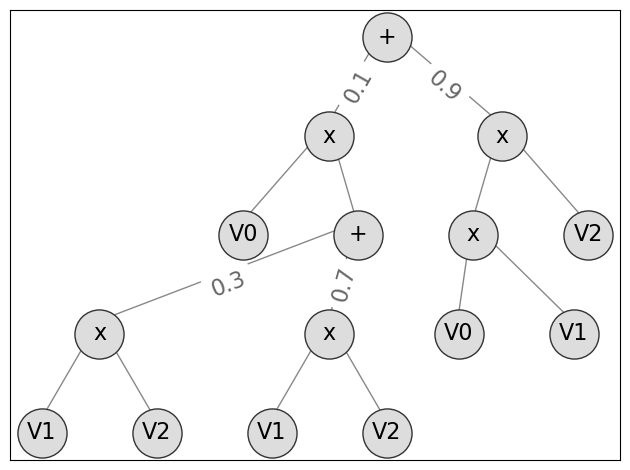

In [60]:
spn = 0.1 * (Categorical(p=[0.2, 0.8], scope=0) *
             (0.3 * (Categorical(p=[0.3, 0.7], scope=1) *
                     Categorical(p=[0.4, 0.6], scope=2))
            + 0.7 * (Categorical(p=[0.5, 0.5], scope=1) *
                     Categorical(p=[0.6, 0.4], scope=2)))) \
    + 0.9 * (Categorical(p=[0.2, 0.8], scope=0) *
             Categorical(p=[0.3, 0.7], scope=1) *
             Categorical(p=[0.4, 0.6], scope=2))


plot_spn(spn, 'basicspn.png')

In [ ]:
np.random.seed(123)
train_data = np.c_[np.r_[np.random.normal((5,5), 1, (500, 2)), np.random.normal(10, 1, (500, 2))],
                   np.r_[np.zeros((500, 1)), np.ones((500, 1))]]

In [ ]:
spn_classification = learn_classifier(train_data,
                     Context(parametric_types=[Gaussian, Gaussian, Categorical]).add_domains(train_data),
                     learn_parametric, 2)
test_classification = np.array([4.0, 5.0, np.nan, 20.0, 12.0, np.nan, 9.0, 10.0, np.nan]).reshape(-1, 3)

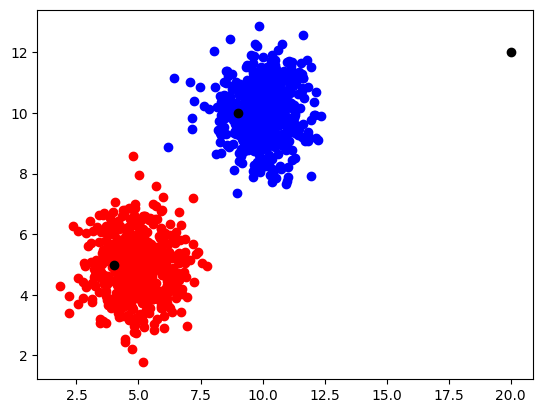

In [ ]:
plt.scatter(train_data[:500,0],train_data[:500,1], color = "red")
plt.scatter(train_data[500:,0],train_data[500:,1], color = "blue")
plt.scatter(test_classification[:,0],test_classification[:,1], color = "black")

In [ ]:
print(mpe(spn_classification, test_classification))

[[ 4.  5.  0.]
 [20. 12.  1.]
 [ 9. 10.  1.]]


/content/gdrive/My Drive/M2/MADI/Projet/Code/spn/structure/leaves/parametric/Inference.py:88: RuntimeWarning: divide by zero encountered in log
  probs[idx_in] = np.array(np.log(node.p))[cat_data[~out_domain_ids]]


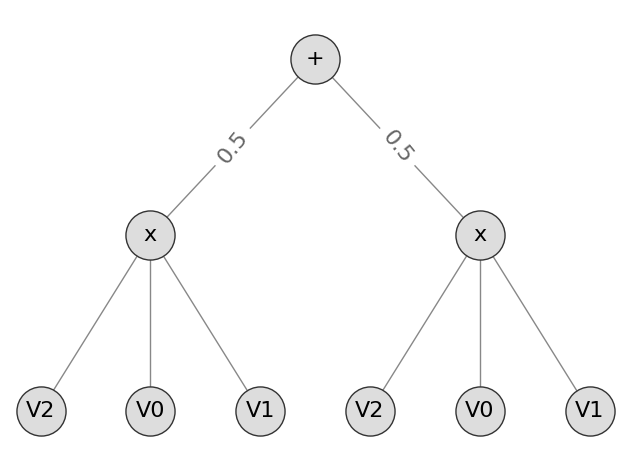

In [ ]:
plot_spn(spn_classification, 'learnedspn.png')

In [ ]:
ll = log_likelihood(spn_classification, test_classification)
print(np.exp(ll))

[[5.06927814e-02]
 [7.59905258e-26]
 [5.12777435e-02]]


/content/gdrive/My Drive/M2/MADI/Projet/Code/spn/structure/leaves/parametric/Inference.py:88: RuntimeWarning: divide by zero encountered in log
  probs[idx_in] = np.array(np.log(node.p))[cat_data[~out_domain_ids]]


## Tests sur l'exemple de l'article

Implémentation du SPN :

In [ ]:
s2 = Sum(weights=[0.6, 0.4], children=[Categorical(p=[0, 1], scope=0), Categorical(p=[0, 1], scope=2)])
s3 = Sum(weights=[0.1, 0.9], children=[Categorical(p=[0, 1], scope=0), Categorical(p=[0, 1], scope=2)])
s4 = Sum(weights=[0.3, 0.7], children=[Categorical(p=[0, 1], scope=1), Categorical(p=[0, 1], scope=3)])
s5 = Sum(weights=[0.8, 0.2], children=[Categorical(p=[0, 1], scope=1), Categorical(p=[0, 1], scope=3)])

p1 = Product(children=[s2,s4])
p2 = Product(children=[s2,s5])
p3 = Product(children=[s3,s5])

s1 = Sum(weights=[0.2, 0.5, 0.3], children=[p1, p2, p3])

assign_ids(s1)
rebuild_scopes_bottom_up(s1)

SumNode_0

Visualisation du SPN :

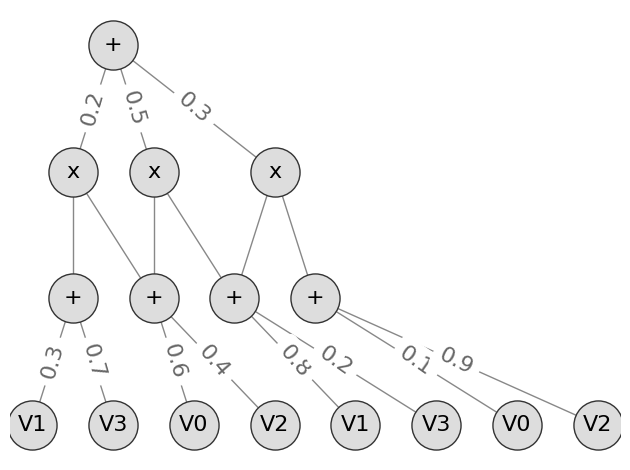

In [ ]:
plot_spn(s1)

Création des données :

In [ ]:
test_classification = np.array([1, 0, 0, 1, np.nan]).reshape(-1,5)

Pour $\lambda = (x_1, x_2, \bar{x}_1, \bar{x}_2) = (1, 0, 0, 1)$, on trouve bien $S(\lambda)=0.15$ :

In [ ]:
l = likelihood(s1, test_classification)
print(l)

[[0.15]]


/content/gdrive/My Drive/M2/MADI/Projet/Code/spn/structure/leaves/parametric/Inference.py:88: RuntimeWarning: divide by zero encountered in log
  probs[idx_in] = np.array(np.log(node.p))[cat_data[~out_domain_ids]]


## Extension d'un SPN à un CSPN par $\epsilon $-contamination

In [63]:
def eps_contamination(spn, eps):
  '''
  Updates the weights of an SPN with epsilon-contamination at the node spn.
  Parameters
  -------------
  Entrées : spn : SPN (ou sous-arbre) ; eps : float
  Sortie : CSPN
  '''
  if isinstance(spn, Sum):
    lw = len(spn.weights)
    for i in range(lw):
      if not(isinstance(spn.weights[i], list)):                                     # Si l'arête n'a pas déjà été 'crédalisée'
        spn.weights[i] = [(1-eps)*spn.weights[i], (1-eps)*spn.weights[i] + eps]
        for child in spn.children:
          eps_contamination(child, eps)
  elif isinstance(spn, Product):
    for child in spn.children:
      eps_contamination(child, eps)
  return spn

def cspn_from_spn(spn, eps):
  '''
  Produces a CSPN from an SPN with epsilon-contamination by calling recursively spn_to_cspn
  Parameters
  -------------
  Entrées : spn : SPN (entier) ; eps : float
  Sortie : CSPN
  '''
  c_spn = copy.deepcopy(spn)
  return eps_contamination(c_spn, eps)

On applique l'$\epsilon$-contamination sur l'exemple de l'article :

In [ ]:
cs1 = cspn_from_spn(s1, 0.1)

On constate que les poids ont correctement été modifiés :

In [ ]:
print("H1 (noeud racine) :", cs1.weights)
print("H2 :", cs1.children[0].children[0].weights)
print("H3 :", cs1.children[2].children[0].weights)
print("H4 :", cs1.children[0].children[1].weights)
print("H5 :", cs1.children[2].children[1].weights)

H1 (noeud racine) : [[0.18000000000000002, 0.28], [0.45, 0.55], [0.27, 0.37]]
H2 : [[0.54, 0.64], [0.36000000000000004, 0.4600000000000001]]
H3 : [[0.09000000000000001, 0.19], [0.81, 0.91]]
H4 : [[0.27, 0.37], [0.63, 0.73]]
H5 : [[0.7200000000000001, 0.8200000000000001], [0.18000000000000002, 0.28]]


## Adaptation du calcul de la vraisemblance

Il faut résoudre deux programmes linéaires lorsque l'on rencontre un noeud SOMME. Pour la borne inférieure de la vraisemblance, le PL est sous la forme :

\begin{equation}
\begin{aligned}
\min \sum_j w_{ij} L^j(\lambda)\\
s.c. \quad w_i \in C_i
\end{aligned}
\end{equation}

Le calcul de la borne supérieure se fait similairement en maximisant cette fonction objectif.

In [64]:
def lower_sum_likelihood(node, children, dtype=np.float64, **kwargs):
    '''
    Calcule la vraisemblance inf à un noeud somme de l'arbre selon le programme linéaire fourni ci-dessus.
    Entrées :
    - node : noeud somme dans le CSPN (type : SPN)
    - children : données dont il faut calculer la vraisemblance (np.array)
    (Remarque : children peut être un tableau comprenant plusieurs évidences, ici, images)
    Sortie : 
    - results : np.array contenant la vraisemblance inf des données d'entrée
    '''
    npChildren = np.concatenate(children, axis=1)
    result = []
    for c in npChildren:
      A_eq = [np.ravel([1 for i in node.weights]).tolist()]
      b_eq = [1]
      result.append(scipy.optimize.linprog(c, A_eq=A_eq, b_eq=b_eq, bounds=[(w[0], w[1]) for w in node.weights]).fun)
    return np.array(result).reshape(npChildren.shape[0],1)

_lower_node_likelihood = _node_likelihood.copy()
_lower_node_likelihood[Sum] = lower_sum_likelihood

def upper_sum_likelihood(node, children, dtype=np.float64, **kwargs):
    '''
    Calcule la vraisemblance sup à un noeud somme de l'arbre selon le programme linéaire fourni ci-dessus.
    Entrées :
    - node : noeud somme dans le CSPN (type : SPN)
    - children : données dont il faut calculer la vraisemblance (np.array)
    (Remarque : children peut être un tableau comprenant plusieurs évidences, ici, images)
    Sortie : 
    - results : np.array contenant la vraisemblance sup des données d'entrée
    '''
    npChildren = np.concatenate(children, axis=1)
    result = []
    for c in npChildren:
      A_eq = [np.ravel([1 for i in node.weights]).tolist()]
      b_eq = [1]
      result.append(-scipy.optimize.linprog(-c, A_eq=A_eq, b_eq=b_eq, bounds=[(w[0], w[1]) for w in node.weights]).fun)
    return np.array(result).reshape(npChildren.shape[0],1)

_upper_node_likelihood = _node_likelihood.copy()
_upper_node_likelihood[Sum] = upper_sum_likelihood

Calcul des vraisemblances inférieure et supérieure de l'exemple et comparaison avec la vraisemblance dans le cas précis :

In [ ]:
lcl = likelihood(cs1, test_classification, node_likelihood = _lower_node_likelihood)
print('Lower likelihood :', lcl)

print('Likelihood :', l)

ucl = likelihood(cs1, test_classification, node_likelihood = _upper_node_likelihood)
print('Upper likelihood :', ucl)

Lower likelihood : [[0.11097]]
Likelihood : [[0.15]]
Upper likelihood : [[0.22582]]


/content/gdrive/My Drive/M2/MADI/Projet/Code/spn/structure/leaves/parametric/Inference.py:88: RuntimeWarning: divide by zero encountered in log
  probs[idx_in] = np.array(np.log(node.p))[cat_data[~out_domain_ids]]


## Dominance crédale pour la classification

Dominance d'intervalle :

In [65]:
def interval_dominance(cspn, dataset, classes):
  '''
  Renvoie la classe la plus probable si elle domine par intervalle les autres.
  Entrées : 
  - cspn : CSPN
  - dataset : np.array (données d'entrée à classifier)
  - classes : list (classes possibles, ici [0,1,2,3,4,5,6,7,8,9])
  Sortie :
  - result : list (pour chaque valeur de dataset contient la classe qui domine par intervalle ou None s'il n'y a pas de classe dominante)
  '''
  result = []
  for d in dataset:
    data = np.tile(d, (len(classes), 1))
    data[:,-1] = classes
    lcl = likelihood(cspn, data, node_likelihood = _lower_node_likelihood)
    ucl = likelihood(cspn, data, node_likelihood = _upper_node_likelihood)
    potential_best = max(ucl)
    index = np.argmax(ucl)
    ucl[index] = -1
    if lcl[index] > max(ucl):
      result.append(classes[index])
    else:
      result.append(None)
  return result

Sur notre exemple issu de l'article, on peut considérer qu'il y a deux classes, $0$ et $1$, et si on demande de prédire la classe par dominance d'intervalle, on trouve bien la classe $1$ :

In [ ]:
test_classification = np.array([1, 0, 0, np.nan]).reshape(1,4)
print(test_classification)

[[ 1.  0.  0. nan]]


In [ ]:
print(interval_dominance(cs1, test_classification, [0,1]))

[1]


## Application au jeu de données

### Chargement des données

On utilise ici le jeu de données *optdigits*.

In [66]:
train_data = pd.read_csv('spn/Dataset/optdigits.tra')
train = train_data.values

test_data = pd.read_csv('spn/Dataset/optdigits.tes')
test = test_data.values

### Apprentissage du SPN à partir des données d'entraînement

In [67]:
spn_classification = learn_classifier(train,
                       Context(parametric_types=[Categorical]*65).add_domains(train),
                       learn_parametric, 64)

c:\Users\loumo\anaconda3\envs\madi_env\Lib\site-packages\sklearn\cross_decomposition\_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
c:\Users\loumo\anaconda3\envs\madi_env\Lib\site-packages\sklearn\cross_decomposition\_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
c:\Users\loumo\anaconda3\envs\madi_env\Lib\site-packages\sklearn\cross_decomposition\_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
c:\Users\loumo\anaconda3\envs\madi_env\Lib\site-packages\sklearn\cross_decomposition\_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
c:\Users\loumo\anaconda3\envs\madi_env\Lib\site-packages\sklearn\cross_decom

### Observation du pourcentage de bonne classification

In [ ]:
train_data_no_class = np.ones((3822,65))*np.nan
train_data_no_class[:,:64] = train[:,:64]

In [8]:
test_data_no_class = np.ones((1796,65))*np.nan
test_data_no_class[:,:64] = test[:,:64]

Sur les données d'entraînement :

In [32]:
pred_im = mpe(spn_classification, train_data_no_class)
nb_im = 3822
nb_err = np.where(pred_im==train,0,1).sum()
acc = (nb_im-nb_err)/nb_im
print(acc)

0.9939822082679226


Sur les données de test :

In [12]:
pred_im = mpe(spn_classification, test_data_no_class)
nb_im = 1796
nb_err = np.where(pred_im==test,0,1).sum()
acc = (nb_im-nb_err)/nb_im
print(acc)

0.6636971046770601


On constate qu'il y a surapprentissage...

### Calculs

In [ ]:
ll = log_likelihood(spn_classification, test)
print(ll)

[[-7.38105090e+001]
 [-1.79769313e+308]
 [-8.95428040e+001]
 ...
 [-1.79769313e+308]
 [-9.33264639e+001]
 [-1.79769313e+308]]


On étend notre SPN à un CSPN avec une valeur $\epsilon = 0.1$ :

In [ ]:
cspn = cspn_from_spn(spn_classification, 0.1)

On applique notre critère de classification :

In [ ]:
print(interval_dominance(cspn, test, [0,1,2,3,4,5,6,7,8,9]))

/content/gdrive/My Drive/M2/MADI/Projet/Code/spn/structure/leaves/parametric/Inference.py:88: RuntimeWarning: divide by zero encountered in log
  probs[idx_in] = np.array(np.log(node.p))[cat_data[~out_domain_ids]]


[1, None, 3, 4, None, None, 7, 8, None, 0, 1, None, None, 4, 5, None, None, 8, None, 0, 1, 2, 3, None, 5, 6, 7, 8, None, None, 9, 5, None, None, 5, 0, None, None, 9, 8, 4, 1, 7, 7, 3, 5, 1, 0, 0, None, None, 7, None, None, None, 1, None, 6, 3, 3, 7, 3, 3, 4, 6, 6, 6, 4, None, 1, None, 0, 9, 5, None, None, None, 0, 0, 1, 7, 6, 3, 2, None, 7, None, 6, None, 1, 3, None, None, 7, None, None, 4, 3, 1, 4, 0, 5, None, 6, None, 6, 1, 7, 5, None, 4, None, 2, 8, None, None, 5, 7, 9, 2, 4, None, 8, 4, 9, 0, 8, None, 1, 0, None, 2, 3, 4, 5, 6, None, 8, 9, 0, None, None, None, None, 5, 6, 7, 8, 9, None, 1, 2, 3, 4, None, 6, None, 8, 9, 0, None, 5, None, 6, 5, 0, 9, None, 9, None, None, None, 7, 7, 3, None, 1, 0, None, 2, 2, None, 8, 2, 0, 1, 2, 6, 3, None, None, 3, 3, None, 6, 6, 6, None, 9, None, 5, 0, 9, None, 2, 8, 2, 0, None, 1, None, 6, 3, 2, 1, None, 3, 1, 3, 9, None, 7, 6, 8, None, 3, 1, None, 0, 5, 3, 6, 9, 6, None, 7, 5, None, None, 7, 2, None, 2, None, None, 5, None, 8, 8, 4, 9, 0, 8, Non

In [68]:
# epsilon = 0.0001
result = [1, None, 3, 4, None, None, 7, 8, None, 0, 1, None, None, 4, 5, None, None, 8, None, 0, 1, 2, 3, None, 5, 6, 7, 8, None, None, 9, 5, None, None, 5, 0, None, None, 9, 8, 4, 1, 7, 7, 3, 5, 1, 0, 0, None, None, 7, None, None, None, 1, None, 6, 3, 3, 7, 3, 3, 4, 6, 6, 6, 4, None, 1, None, 0, 9, 5, None, None, None, 0, 0, 1, 7, 6, 3, 2, None, 7, None, 6, None, 1, 3, None, None, 7, None, None, 4, 3, 1, 4, 0, 5, None, 6, None, 6, 1, 7, 5, None, 4, None, 2, 8, None, None, 5, 7, 9, 2, 4, None, 8, 4, 9, 0, 8, None, 1, 0, None, 2, 3, 4, 5, 6, None, 8, 9, 0, None, None, None, None, 5, 6, 7, 8, 9, None, 1, 2, 3, 4, None, 6, None, 8, 9, 0, None, 5, None, 6, 5, 0, 9, None, 9, None, None, None, 7, 7, 3, None, 1, 0, None, 2, 2, None, 8, 2, 0, 1, 2, 6, 3, None, None, 3, 3, None, 6, 6, 6, None, 9, None, 5, 0, 9, None, 2, 8, 2, 0, None, 1, None, 6, 3, 2, 1, None, 3, 1, 3, 9, None, 7, 6, 8, None, 3, 1, None, 0, 5, 3, 6, 9, 6, None, 7, 5, None, None, 7, 2, None, 2, None, None, 5, None, 8, 8, 4, 9, 0, 8, None, 8, 0, None, 2, 3, 4, 5, 6, None, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, None, 9, 0, 1, 2, 3, 4, 5, 6, None, 8, 9, None, 5, 5, 5, 6, 5, None, 9, 8, 9, 8, 4, 1, 7, 7, 3, 5, None, 0, 0, None, 2, 7, 8, 2, 0, 1, None, 8, 3, 3, 7, 3, 3, 4, 6, 6, 6, None, 9, 1, None, 0, 4, 5, 2, 8, None, 0, 0, None, None, 6, 3, 2, 1, 7, 4, 6, 3, 1, 3, 9, 1, 7, 6, 8, 4, 3, None, 4, None, 5, 3, 6, 9, 6, None, None, 5, None, 4, 7, 2, 8, None, None, 5, 7, 9, 5, 4, 8, 8, 4, 9, 0, None, 9, None, 0, 1, 2, 3, None, 5, 6, 9, 8, 9, 0, 1, None, None, None, 5, None, 7, None, 9, 0, 1, 2, None, None, 5, None, None, None, 9, 0, None, 5, 5, None, None, 0, 9, 8, 9, 8, 4, 1, 9, 9, 3, 5, 1, 0, 0, 2, 2, None, None, 2, 0, None, 2, None, None, 5, None, 8, 3, 4, None, 6, 6, 1, 9, 1, 5, 0, 9, 5, 2, 8, 2, 0, 0, 1, None, 6, 8, 2, 1, 9, 4, None, 3, 1, None, 5, 1, 9, None, None, None, 3, None, None, 0, None, None, 6, 9, None, 1, None, 5, 4, None, None, 2, None, 2, None, 5, 9, 8, 5, 4, 8, 8, None, None, 0, None, 9, 8, 0, 1, 2, None, 4, None, 6, 8, None, None, 0, None, None, None, 4, 5, 6, 7, None, None, 0, None, None, None, None, 5, 6, 7, 8, None, 0, None, 5, 5, 8, 5, 0, 9, None, 9, None, 4, None, 7, 7, 5, 5, None, 0, 0, None, 2, 7, None, 2, 0, None, 2, 6, None, None, 7, None, None, 4, None, None, None, 4, None, None, 5, None, 9, None, None, 8, None, 0, None, None, 7, None, None, None, None, 7, None, None, None, None, None, 9, None, 7, 6, None, 4, None, 1, None, None, 5, 5, None, 9, None, None, 7, 5, None, 4, None, None, 8, None, None, None, 7, 9, 5, None, None, None, None, 9, 0, None, None, None, None, 1, None, 3, None, 5, 6, 7, 8, 9, None, 1, None, 5, 4, 5, 6, 7, 8, 9, None, 1, None, 3, None, 5, 6, None, 8, None, 0, None, None, 5, 6, None, 0, None, 8, None, 8, None, None, None, None, None, 5, None, 0, 0, 2, None, 7, 8, None, None, 1, None, 6, 3, 3, 7, 3, 3, 4, 6, 6, 6, None, 9, None, 5, 0, 1, 5, None, None, None, 0, 0, 1, 7, None, None, 2, None, 7, 4, 6, None, None, 3, 9, 8, 7, 6, 8, 4, 3, 8, None, 0, 5, 3, 6, 9, 6, None, 7, 5, None, None, 7, 8, None, None, None, 5, 7, 4, 5, None, 8, 8, 4, 9, 0, 8, 9, 8, None, 1, 2, None, None, None, None, 7, None, 9, 0, None, 2, 3, 4, 5, None, 7, None, None, None, 1, 2, 3, 4, 5, None, 7, None, None, 0, 5, None, 5, 6, 5, 0, None, 8, 9, None, 4, 1, None, 7, 3, 5, 1, 0, 0, 2, None, None, None, 2, 0, None, 2, None, None, None, 7, None, None, 4, None, 6, None, 4, None, 1, 5, 0, 9, 5, 2, 8, 2, 0, 0, 8, None, 6, 3, 2, 1, 7, None, None, 3, 1, 3, 9, 1, 7, 6, None, None, 3, 8, 4, 0, 5, 3, None, 9, 6, None, 7, 5, 4, 4, 7, 2, 8, 7, 8, None, None, None, 5, None, 8, None, None, 8, 0, 8, 9, None, None, 2, None, 4, 5, 6, 4, 8, None, 0, None, 2, None, 4, 5, 6, None, 8, 9, 0, None, 2, 3, 4, 5, 6, 9, 8, 5, 0, None, 5, 5, 6, 5, 0, 9, 8, 9, 8, 4, 1, None, 9, None, None, None, 2, None, 8, 2, 0, None, 2, 6, 3, 8, None, None, None, None, 6, 6, 6, None, None, 1, 5, None, None, 5, 2, None, 2, None, None, 1, 7, 6, None, 2, None, None, 6, 3, None, None, 9, 1, 4, None, None, None, None, None, None, 0, 5, None, 6, 9, 6, 1, None, 5, 4, 4, 7, 2, 8, 2, 2, 5, None, 9, 5, None, 4, None, None, 8, 9, 8, 0, 1, 2, 3, 4, 5, 6, 7, 8, 5, 0, 1, 2, 5, 4, 5, 6, None, 8, 5, 0, 1, 2, 3, 4, 5, 6, None, None, 9, 0, 9, None, None, 6, None, 0, None, None, 9, 8, None, 8, None, 9, 9, 5, 1, None, None, 7, None, 2, None, 1, 2, 6, None, 3, None, 3, None, 4, 6, None, 6, 4, 5, 1, 5, 0, None, 5, None, 8, 2, None, 0, 1, 7, 6, 3, 2, 1, None, 4, 6, 3, 8, None, None, 1, None, None, 8, 4, 9, 1, 4, 0, 5, None, 6, None, 6, 1, 7, 5, 4, 4, 7, 2, 8, None, 2, 5, None, None, 5, 4, None, 8, 4, None, 0, None, None, None, 0, 1, 2, None, 4, 5, 6, 7, None, 9, 0, 1, 2, 3, 4, 5, None, 7, None, None, 0, 1, None, 9, 4, 5, 6, 7, 8, None, 5, 9, 5, 5, 6, 5, None, 9, None, 9, None, 4, None, None, 7, None, None, None, None, None, 2, None, 7, None, 2, None, 1, None, 6, 3, 3, 7, 3, 3, None, 6, 6, 6, 4, 9, 1, 5, None, None, 5, 2, 8, 2, 0, 0, 1, 7, 6, 3, None, None, None, 4, 6, 3, 1, None, 9, 1, 7, None, 8, 4, 3, 1, 4, 0, None, 3, 6, 9, None, None, 7, 5, 4, 4, 7, 2, None, None, None, None, 7, 9, None, 4, 8, 8, 4, 9, None, 8, 9, 8, 0, 9, 2, None, None, 5, None, 7, 8, None, None, None, None, 3, None, None, None, 7, None, 9, 0, None, 2, 3, None, 5, None, 7, None, 9, 0, None, 5, 5, None, 5, 0, 9, 8, 5, 8, None, 1, 3, 7, 3, 5, 8, None, None, None, None, 7, 8, None, None, None, None, 6, 3, 3, 7, None, 3, 4, 6, None, 6, 4, 9, 1, 5, 0, 9, 5, 2, 8, None, 0, None, 1, None, None, 3, None, None, 7, None, None, 3, 1, 3, 9, 1, 7, None, 8, None, 3, 1, 4, 0, None, None, None, 9, None, 1, None, 5, None, 4, 7, None, 8, 2, None, 5, 7, None, 5, 4, 8, 8, None, None, None, 8, None, None, 2, 3, None, 5, 6, 9, 3, 9, 0, None, None, 3, 4, 5, 6, None, 8, 9, None, 1, 2, 3, None, None, 6, 7, None, 9, 0, 9, 5, 5, 6, 5, 0, 9, 8, 9, None, 4, None, None, None, 3, 5, None, 0, 0, 2, 2, 7, None, 2, None, None, None, 6, 3, 3, 7, 3, 3, None, 6, 6, 6, None, 9, None, 5, None, None, 5, 2, 3, 2, 0, 0, None, 9, 6, 3, 2, None, 7, 4, 6, 3, 1, 3, 9, None, 3, 6, None, 4, 3, None, 4, 0, 5, 3, 6, 9, 6, None, 9, 5, 4, 4, None, 2, None, 2, 2, 5, None, 9, 5, 4, 8, 8, 4, 9, 0, 4, 9, 8, 0, 1, 2, None, 4, 5, None, None, 1, 9, 0, 1, 2, 3, 4, 5, None, 9, 0, 1, None, 3, 4, 5, None, None, None, None, None, 9, None, None, None, 5, 0, None, None, None, 8, 4, None, 7, None, None, None, 1, None, 0, None, 2, None, 8, None, 0, None, None, None, None, None, None, 7, None, 4, None, None, 6, None, 9, 1, 5, None, 9, 4, None, None, None, 1, 7, None, 3, 2, 1, None, None, None, 3, 1, 9, 9, 1, None, None, 8, None, 3, 1, 4, 0, None, 3, 1, 3, 6, None, 7, 5, 4, 4, 7, None, 2, None, None, 8, 5, 8, 4, None, 0, None, 9, None, 0, None, 2, None, None, 5, 6, 7, 8, 9, 0, 1, 2, None, None, 5, 6, 7, 8, 9, None, 1, None, None, 4, 5, 6, 7, None, 9, 0, 9, 5, 5, 6, None, 0, 9, 8, 9, None, 4, 1, None, 7, None, 5, 1, 0, None, None, 2, 7, 8, 2, None, 1, None, 6, 3, None, None, None, None, 4, None, 6, 6, 4, 9, 4, 5, 0, 9, None, None, 8, 2, 0, 0, 1, 7, 6, 3, None, 1, None, 4, 6, 3, 1, None, 9, 1, 7, 6, 8, None, 8, 1, 4, None, 5, 3, None, 9, 6, 1, 7, 5, 4, 4, None, 2, 8, 2, 2, 5, 7, 9, 5, 4, 8, 8, 4, 9, 0, None, 9, None]

In [69]:
# epsilon = 0.005
result = [1, None, 3, 4, None, None, 7, 8, None, 0, 1, None, None, 4, 5, None, None, 8, None, 0, 1, 2, 3, None, 5, 6, 7, 8, None, None, 9, 5, None, None, 5, 0, None, None, 9, 8, 4, 1, 7, 7, 3, 5, 1, 0, 0, None, None, 7, None, None, None, 1, None, 6, 3, 3, 7, 3, 3, 4, 6, 6, 6, 4, None, 1, None, 0, 9, 5, None, None, None, 0, 0, 1, 7, 6, 3, 2, None, 7, None, 6, None, 1, 3, None, None, 7, None, None, 4, 3, 1, 4, 0, 5, None, 6, None, 6, 1, 7, 5, None, 4, None, 2, 8, None, None, 5, 7, 9, 2, 4, None, 8, 4, 9, 0, 8, None, 1, 0, None, 2, 3, 4, 5, 6, None, 8, 9, 0, None, None, None, None, 5, 6, 7, 8, 9, None, 1, 2, 3, 4, None, 6, None, 8, 9, 0, None, 5, None, 6, 5, 0, 9, None, 9, None, None, None, 7, 7, 3, None, 1, 0, None, 2, 2, None, 8, 2, 0, 1, 2, 6, 3, None, None, 3, 3, None, 6, 6, 6, None, 9, None, 5, 0, 9, None, 2, 8, 2, 0, None, 1, None, 6, 3, 2, 1, None, 3, 1, 3, 9, None, 7, 6, 8, None, 3, 1, None, 0, 5, 3, 6, 9, 6, None, 7, 5, None, None, 7, 2, None, 2, None, None, 5, None, 8, 8, 4, 9, 0, 8, None, 8, 0, None, 2, 3, 4, 5, 6, None, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, None, 9, 0, 1, 2, 3, 4, 5, 6, None, 8, 9, None, 5, 5, 5, 6, 5, None, 9, 8, 9, 8, 4, 1, 7, 7, 3, 5, None, 0, 0, None, 2, 7, 8, 2, 0, 1, None, 8, 3, 3, 7, 3, 3, 4, 6, 6, 6, None, 9, 1, None, 0, 4, 5, 2, 8, None, 0, 0, None, None, 6, 3, 2, 1, 7, 4, 6, 3, 1, 3, 9, 1, 7, 6, 8, 4, 3, None, 4, None, 5, 3, 6, 9, 6, None, None, 5, None, 4, 7, 2, 8, None, None, 5, 7, 9, 5, 4, 8, 8, 4, 9, 0, None, 9, None, 0, 1, 2, 3, None, 5, 6, 9, 8, 9, 0, 1, None, None, None, 5, None, 7, None, 9, 0, 1, 2, None, None, 5, None, None, None, 9, 0, None, 5, 5, None, None, 0, 9, 8, 9, 8, 4, 1, 9, 9, 3, 5, 1, 0, 0, 2, 2, None, None, 2, 0, None, 2, None, None, 5, None, 8, 3, 4, None, 6, 6, 1, 9, 1, 5, 0, 9, 5, 2, 8, 2, 0, 0, 1, None, 6, 8, 2, 1, 9, 4, None, 3, 1, None, 5, 1, 9, None, None, None, 3, None, None, 0, None, None, 6, 9, None, 1, None, 5, 4, None, None, 2, None, 2, None, 5, 9, 8, 5, 4, 8, 8, None, None, 0, None, 9, 8, 0, 1, 2, None, 4, None, 6, 8, None, None, 0, None, None, None, 4, 5, 6, 7, None, None, 0, None, None, None, None, 5, 6, 7, 8, None, 0, None, 5, 5, 8, 5, 0, 9, None, 9, None, 4, None, 7, 7, 5, 5, None, 0, 0, None, 2, 7, None, 2, 0, None, 2, 6, None, None, 7, None, None, 4, None, None, None, 4, None, None, 5, None, 9, None, None, 8, None, 0, None, None, 7, None, None, None, None, 7, None, None, None, None, None, 9, None, 7, 6, None, 4, None, 1, None, None, 5, 5, None, 9, None, None, 7, 5, None, 4, None, None, 8, None, None, None, 7, 9, 5, None, None, None, None, 9, 0, None, None, None, None, 1, None, 3, None, 5, 6, 7, 8, 9, None, 1, None, 5, 4, 5, 6, 7, 8, 9, None, 1, None, 3, None, 5, 6, None, 8, None, 0, None, None, 5, 6, None, 0, None, 8, None, 8, None, None, None, None, None, 5, None, 0, 0, 2, None, 7, 8, None, None, 1, None, 6, 3, 3, 7, 3, 3, 4, 6, 6, 6, None, 9, None, 5, 0, 1, 5, None, None, None, 0, 0, 1, 7, None, None, 2, None, 7, 4, 6, None, None, 3, 9, 8, 7, 6, 8, 4, 3, 8, None, 0, 5, 3, 6, 9, 6, None, 7, 5, None, None, 7, 8, None, None, None, 5, 7, 4, 5, None, 8, 8, 4, 9, 0, 8, 9, 8, None, 1, 2, None, None, None, None, 7, None, 9, 0, None, 2, 3, 4, 5, None, 7, None, None, None, 1, 2, 3, 4, 5, None, 7, None, None, 0, 5, None, 5, 6, 5, 0, None, 8, 9, None, 4, 1, None, 7, 3, 5, 1, 0, 0, 2, None, None, None, 2, 0, None, 2, None, None, None, 7, None, None, 4, None, 6, None, 4, None, 1, 5, 0, 9, 5, 2, 8, 2, 0, 0, 8, None, 6, 3, 2, 1, 7, None, None, 3, 1, 3, 9, 1, 7, 6, None, None, 3, 8, 4, 0, 5, 3, None, 9, 6, None, 7, 5, 4, 4, 7, 2, 8, 7, 8, None, None, None, 5, None, 8, None, None, 8, 0, 8, 9, None, None, 2, None, 4, 5, 6, 4, 8, None, 0, None, 2, None, 4, 5, 6, None, 8, 9, 0, None, 2, 3, 4, 5, 6, 9, 8, 5, 0, None, 5, 5, 6, 5, 0, 9, 8, 9, 8, 4, 1, None, 9, None, None, None, 2, None, 8, 2, 0, None, 2, 6, 3, 8, None, None, None, None, 6, 6, 6, None, None, 1, 5, None, None, 5, 2, None, 2, None, None, 1, 7, 6, None, 2, None, None, 6, 3, None, None, 9, 1, 4, None, None, None, None, None, None, 0, 5, None, 6, 9, 6, 1, None, 5, 4, 4, 7, 2, 8, 2, 2, 5, None, 9, 5, None, 4, None, None, 8, 9, 8, 0, 1, 2, 3, 4, 5, 6, 7, 8, 5, 0, 1, 2, 5, 4, 5, 6, None, 8, 5, 0, 1, 2, 3, 4, 5, 6, None, None, 9, 0, 9, None, None, 6, None, 0, None, None, 9, 8, None, 8, None, 9, 9, 5, 1, None, None, 7, None, 2, None, 1, 2, 6, None, 3, None, 3, None, 4, 6, None, 6, 4, 5, 1, 5, 0, None, 5, None, 8, 2, None, 0, 1, 7, 6, 3, 2, 1, None, 4, 6, 3, 8, None, None, 1, None, None, 8, 4, 9, 1, 4, 0, 5, None, 6, None, 6, 1, 7, 5, 4, 4, 7, 2, 8, None, 2, 5, None, None, 5, 4, None, 8, 4, None, 0, None, None, None, 0, 1, 2, None, 4, 5, 6, 7, None, 9, 0, 1, 2, 3, 4, 5, None, 7, None, None, 0, 1, None, 9, 4, 5, 6, 7, 8, None, 5, 9, 5, 5, 6, 5, None, 9, None, 9, None, 4, None, None, 7, None, None, None, None, None, 2, None, 7, None, 2, None, 1, None, 6, 3, 3, 7, 3, 3, None, 6, 6, 6, 4, 9, 1, 5, None, None, 5, 2, 8, 2, 0, 0, 1, 7, 6, 3, None, None, None, 4, 6, 3, 1, None, 9, 1, 7, None, 8, 4, 3, 1, 4, 0, None, 3, 6, 9, None, None, 7, 5, 4, 4, 7, 2, None, None, None, None, 7, 9, None, 4, 8, 8, 4, 9, None, 8, 9, 8, 0, 9, 2, None, None, 5, None, 7, 8, None, None, None, None, 3, None, None, None, 7, None, 9, 0, None, 2, 3, None, 5, None, 7, None, 9, 0, None, 5, 5, None, 5, 0, 9, 8, 5, 8, None, 1, 3, 7, 3, 5, 8, None, None, None, None, 7, 8, None, None, None, None, 6, 3, 3, 7, None, 3, 4, 6, None, 6, 4, 9, 1, 5, 0, 9, 5, 2, 8, None, 0, None, 1, None, None, 3, None, None, 7, None, None, 3, 1, 3, 9, 1, 7, None, 8, None, 3, 1, 4, 0, None, None, None, 9, None, 1, None, 5, None, 4, 7, None, 8, 2, None, 5, 7, None, 5, 4, 8, 8, None, None, None, 8, None, None, 2, 3, None, 5, 6, 9, 3, 9, 0, None, None, 3, 4, 5, 6, None, 8, 9, None, 1, 2, 3, None, None, 6, 7, None, 9, 0, 9, 5, 5, 6, 5, 0, 9, 8, 9, None, 4, None, None, None, 3, 5, None, 0, 0, 2, 2, 7, None, 2, None, None, None, 6, 3, 3, 7, 3, 3, None, 6, 6, 6, None, 9, None, 5, None, None, 5, 2, 3, 2, 0, 0, None, 9, 6, 3, 2, None, 7, 4, 6, 3, 1, 3, 9, None, 3, 6, None, 4, 3, None, 4, 0, 5, 3, 6, 9, 6, None, 9, 5, 4, 4, None, 2, None, 2, 2, 5, None, 9, 5, 4, 8, 8, 4, 9, 0, 4, 9, 8, 0, 1, 2, None, 4, 5, None, None, 1, 9, 0, 1, 2, 3, 4, 5, None, 9, 0, 1, None, 3, 4, 5, None, None, None, None, None, 9, None, None, None, 5, 0, None, None, None, 8, 4, None, 7, None, None, None, 1, None, 0, None, 2, None, 8, None, 0, None, None, None, None, None, None, 7, None, 4, None, None, 6, None, 9, 1, 5, None, 9, 4, None, None, None, 1, 7, None, 3, 2, 1, None, None, None, 3, 1, 9, 9, 1, None, None, 8, None, 3, 1, 4, 0, None, 3, 1, 3, 6, None, 7, 5, 4, 4, 7, None, 2, None, None, 8, 5, 8, 4, None, 0, None, 9, None, 0, None, 2, None, None, 5, 6, 7, 8, 9, 0, 1, 2, None, None, 5, 6, 7, 8, 9, None, 1, None, None, 4, 5, 6, 7, None, 9, 0, 9, 5, 5, 6, None, 0, 9, 8, 9, None, 4, 1, None, 7, None, 5, 1, 0, None, None, 2, 7, 8, 2, None, 1, None, 6, 3, None, None, None, None, 4, None, 6, 6, 4, 9, 4, 5, 0, 9, None, None, 8, 2, 0, 0, 1, 7, 6, 3, None, 1, None, 4, 6, 3, 1, None, 9, 1, 7, 6, 8, None, 8, 1, 4, None, 5, 3, None, 9, 6, 1, 7, 5, 4, 4, None, 2, 8, 2, 2, 5, 7, 9, 5, 4, 8, 8, 4, 9, 0, None, 9, None]

In [70]:
# epsilon = 0.01
result = [1, None, 3, 4, None, None, 7, 8, None, 0, 1, None, None, 4, 5, None, None, 8, None, 0, 1, 2, 3, None, 5, 6, 7, 8, None, None, 9, 5, None, None, 5, 0, None, None, 9, 8, 4, 1, 7, 7, 3, 5, 1, 0, 0, None, None, 7, None, None, None, 1, None, 6, 3, 3, 7, 3, 3, 4, 6, 6, 6, 4, None, 1, None, 0, 9, 5, None, None, None, 0, 0, 1, 7, 6, 3, 2, None, 7, None, 6, None, 1, 3, None, None, 7, None, None, 4, 3, 1, 4, 0, 5, None, 6, None, 6, 1, 7, 5, None, 4, None, 2, 8, None, None, 5, 7, 9, 2, 4, None, 8, 4, 9, 0, 8, None, 1, 0, None, 2, 3, 4, 5, 6, None, 8, 9, 0, None, None, None, None, 5, 6, 7, 8, 9, None, 1, 2, 3, 4, None, 6, None, 8, 9, 0, None, 5, None, 6, 5, 0, 9, None, 9, None, None, None, 7, 7, 3, None, 1, 0, None, 2, 2, None, 8, 2, 0, 1, 2, 6, 3, None, None, 3, 3, None, 6, 6, 6, None, 9, None, 5, 0, 9, None, 2, 8, 2, 0, None, 1, None, 6, 3, 2, 1, None, 3, 1, 3, 9, None, 7, 6, 8, None, 3, 1, None, 0, 5, 3, 6, 9, 6, None, 7, 5, None, None, 7, 2, None, 2, None, None, 5, None, 8, 8, 4, 9, 0, 8, None, 8, 0, None, 2, 3, 4, 5, 6, None, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, None, 9, 0, 1, 2, 3, 4, 5, 6, None, 8, 9, None, 5, 5, 5, 6, 5, None, 9, 8, 9, 8, 4, 1, 7, 7, 3, 5, None, 0, 0, None, 2, 7, 8, 2, 0, 1, None, 8, 3, 3, 7, 3, 3, 4, 6, 6, 6, None, 9, 1, None, 0, 4, 5, 2, 8, None, 0, 0, None, None, 6, 3, 2, 1, 7, 4, 6, 3, 1, 3, 9, 1, 7, 6, 8, 4, 3, None, 4, None, 5, 3, 6, 9, 6, None, None, 5, None, 4, 7, 2, 8, None, None, 5, 7, 9, 5, 4, 8, 8, 4, 9, 0, None, 9, None, 0, 1, 2, 3, None, 5, 6, 9, 8, 9, 0, 1, None, None, None, 5, None, 7, None, 9, 0, 1, 2, None, None, 5, None, None, None, 9, 0, None, 5, 5, None, None, 0, 9, 8, 9, 8, 4, 1, 9, 9, 3, 5, 1, 0, 0, 2, 2, None, None, 2, 0, None, 2, None, None, 5, None, 8, 3, 4, None, 6, 6, 1, 9, 1, 5, 0, 9, 5, 2, 8, 2, 0, 0, 1, None, 6, 8, 2, 1, 9, 4, None, 3, 1, None, 5, 1, 9, None, None, None, 3, None, None, 0, None, None, 6, 9, None, 1, None, 5, 4, None, None, 2, None, 2, None, 5, 9, 8, 5, 4, 8, 8, None, None, 0, None, 9, 8, 0, 1, 2, None, 4, None, 6, 8, None, None, 0, None, None, None, 4, 5, 6, 7, None, None, 0, None, None, None, None, 5, 6, 7, 8, None, 0, None, 5, 5, 8, 5, 0, 9, None, 9, None, 4, None, 7, 7, 5, 5, None, 0, 0, None, 2, 7, None, 2, 0, None, 2, 6, None, None, 7, None, None, 4, None, None, None, 4, None, None, 5, None, 9, None, None, 8, None, 0, None, None, 7, None, None, None, None, 7, None, None, None, None, None, 9, None, 7, 6, None, 4, None, 1, None, None, 5, 5, None, 9, None, None, 7, 5, None, 4, None, None, 8, None, None, None, 7, 9, 5, None, None, None, None, 9, 0, None, None, None, None, 1, None, 3, None, 5, 6, 7, 8, 9, None, 1, None, 5, 4, 5, 6, 7, 8, 9, None, 1, None, 3, None, 5, 6, None, 8, None, 0, None, None, 5, 6, None, 0, None, 8, None, 8, None, None, None, None, None, 5, None, 0, 0, 2, None, 7, 8, None, None, 1, None, 6, 3, 3, 7, 3, 3, 4, 6, 6, 6, None, 9, None, 5, 0, 1, 5, None, None, None, 0, 0, 1, 7, None, None, 2, None, 7, 4, 6, None, None, 3, 9, 8, 7, 6, 8, 4, 3, 8, None, 0, 5, 3, 6, 9, 6, None, 7, 5, None, None, 7, 8, None, None, None, 5, 7, 4, 5, None, 8, 8, 4, 9, 0, 8, 9, 8, None, 1, 2, None, None, None, None, 7, None, 9, 0, None, 2, 3, 4, 5, None, 7, None, None, None, 1, 2, 3, 4, 5, None, 7, None, None, 0, 5, None, 5, 6, 5, 0, None, 8, 9, None, 4, 1, None, 7, 3, 5, 1, 0, 0, 2, None, None, None, 2, 0, None, 2, None, None, None, 7, None, None, 4, None, 6, None, 4, None, 1, 5, 0, 9, 5, 2, 8, 2, 0, 0, 8, None, 6, 3, 2, 1, 7, None, None, 3, 1, 3, 9, 1, 7, 6, None, None, 3, 8, 4, 0, 5, 3, None, 9, 6, None, 7, 5, 4, 4, 7, 2, 8, 7, 8, None, None, None, 5, None, 8, None, None, 8, 0, 8, 9, None, None, 2, None, 4, 5, 6, 4, 8, None, 0, None, 2, None, 4, 5, 6, None, 8, 9, 0, None, 2, 3, 4, 5, 6, 9, 8, 5, 0, None, 5, 5, 6, 5, 0, 9, 8, 9, 8, 4, 1, None, 9, None, None, None, 2, None, 8, 2, 0, None, 2, 6, 3, 8, None, None, None, None, 6, 6, 6, None, None, 1, 5, None, None, 5, 2, None, 2, None, None, 1, 7, 6, None, 2, None, None, 6, 3, None, None, 9, 1, 4, None, None, None, None, None, None, 0, 5, None, 6, 9, 6, 1, None, 5, 4, 4, 7, 2, 8, 2, 2, 5, None, 9, 5, None, 4, None, None, 8, 9, 8, 0, 1, 2, 3, 4, 5, 6, 7, 8, 5, 0, 1, 2, 5, 4, 5, 6, None, 8, 5, 0, 1, 2, 3, 4, 5, 6, None, None, 9, 0, 9, None, None, 6, None, 0, None, None, 9, 8, None, 8, None, 9, 9, 5, 1, None, None, 7, None, 2, None, 1, 2, 6, None, 3, None, 3, None, 4, 6, None, 6, 4, 5, 1, 5, 0, None, 5, None, 8, 2, None, 0, 1, 7, 6, 3, 2, 1, None, 4, 6, 3, 8, None, None, 1, None, None, 8, 4, 9, 1, 4, 0, 5, None, 6, None, 6, 1, 7, 5, 4, 4, 7, 2, 8, None, 2, 5, None, None, 5, 4, None, 8, 4, None, 0, None, None, None, 0, 1, 2, None, 4, 5, 6, 7, None, 9, 0, 1, 2, 3, 4, 5, None, 7, None, None, 0, 1, None, 9, 4, 5, 6, 7, 8, None, 5, 9, 5, 5, 6, 5, None, 9, None, 9, None, 4, None, None, 7, None, None, None, None, None, 2, None, 7, None, 2, None, 1, None, 6, 3, 3, 7, 3, 3, None, 6, 6, 6, 4, 9, 1, 5, None, None, 5, 2, 8, 2, 0, 0, 1, 7, 6, 3, None, None, None, 4, 6, 3, 1, None, 9, 1, 7, None, 8, 4, 3, 1, 4, 0, None, 3, 6, 9, None, None, 7, 5, 4, 4, 7, 2, None, None, None, None, 7, 9, None, 4, 8, 8, 4, 9, None, 8, 9, 8, 0, 9, 2, None, None, 5, None, 7, 8, None, None, None, None, 3, None, None, None, 7, None, 9, 0, None, 2, 3, None, 5, None, 7, None, 9, 0, None, 5, 5, None, 5, 0, 9, 8, 5, 8, None, 1, 3, 7, 3, 5, 8, None, None, None, None, 7, 8, None, None, None, None, 6, 3, 3, 7, None, 3, 4, 6, None, 6, 4, 9, 1, 5, 0, 9, 5, 2, 8, None, 0, None, 1, None, None, 3, None, None, 7, None, None, 3, 1, 3, 9, 1, 7, None, 8, None, 3, 1, 4, 0, None, None, None, 9, None, 1, None, 5, None, 4, 7, None, 8, 2, None, 5, 7, None, 5, 4, 8, 8, None, None, None, 8, None, None, 2, 3, None, 5, 6, 9, 3, 9, 0, None, None, 3, 4, 5, 6, None, 8, 9, None, 1, 2, 3, None, None, 6, 7, None, 9, 0, 9, 5, 5, 6, 5, 0, 9, 8, 9, None, 4, None, None, None, 3, 5, None, 0, 0, 2, 2, 7, None, 2, None, None, None, 6, 3, 3, 7, 3, 3, None, 6, 6, 6, None, 9, None, 5, None, None, 5, 2, 3, 2, 0, 0, None, 9, 6, 3, 2, None, 7, 4, 6, 3, 1, 3, 9, None, 3, 6, None, 4, 3, None, 4, 0, 5, 3, 6, 9, 6, None, 9, 5, 4, 4, None, 2, None, 2, 2, 5, None, 9, 5, 4, 8, 8, 4, 9, 0, 4, 9, 8, 0, 1, 2, None, 4, 5, None, None, 1, 9, 0, 1, 2, 3, 4, 5, None, 9, 0, 1, None, 3, 4, 5, None, None, None, None, None, 9, None, None, None, 5, 0, None, None, None, 8, 4, None, 7, None, None, None, 1, None, 0, None, 2, None, 8, None, 0, None, None, None, None, None, None, 7, None, 4, None, None, 6, None, 9, 1, 5, None, 9, 4, None, None, None, 1, 7, None, 3, 2, 1, None, None, None, 3, 1, 9, 9, 1, None, None, 8, None, 3, 1, 4, 0, None, 3, 1, 3, 6, None, 7, 5, 4, 4, 7, None, 2, None, None, 8, 5, 8, 4, None, 0, None, 9, None, 0, None, 2, None, None, 5, 6, 7, 8, 9, 0, 1, 2, None, None, 5, 6, 7, 8, 9, None, 1, None, None, 4, 5, 6, 7, None, 9, 0, 9, 5, 5, 6, None, 0, 9, 8, 9, None, 4, 1, None, 7, None, 5, 1, 0, None, None, 2, 7, 8, 2, None, 1, None, 6, 3, None, None, None, None, 4, None, 6, 6, 4, 9, 4, 5, 0, 9, None, None, 8, 2, 0, 0, 1, 7, 6, 3, None, 1, None, 4, 6, 3, 1, None, 9, 1, 7, 6, 8, None, 8, 1, 4, None, 5, 3, None, 9, 6, 1, 7, 5, 4, 4, None, 2, 8, 2, 2, 5, 7, 9, 5, 4, 8, 8, 4, 9, 0, None, 9, None]

In [71]:
# epsilon = 0.1
result = [1, None, 3, 4, None, None, 7, 8, None, 0, 1, None, None, 4, 5, None, None, 8, None, 0, 1, 2, 3, None, 5, 6, 7, 8, None, None, 9, 5, None, None, 5, 0, None, None, 9, 8, 4, 1, 7, 7, 3, 5, 1, 0, 0, None, None, 7, None, None, None, 1, None, 6, 3, 3, 7, 3, 3, 4, 6, 6, 6, 4, None, 1, None, 0, 9, 5, None, None, None, 0, 0, 1, 7, 6, 3, 2, None, 7, None, 6, None, 1, 3, None, None, 7, None, None, 4, 3, 1, 4, 0, 5, None, 6, None, 6, 1, 7, 5, None, 4, None, 2, 8, None, None, 5, 7, 9, 2, 4, None, 8, 4, 9, 0, 8, None, 1, 0, None, 2, 3, 4, 5, 6, None, 8, 9, 0, None, None, None, None, 5, 6, 7, 8, 9, None, 1, 2, 3, 4, None, 6, None, 8, 9, 0, None, 5, None, 6, 5, 0, 9, None, 9, None, None, None, 7, 7, 3, None, 1, 0, None, 2, 2, None, 8, 2, 0, 1, 2, 6, 3, None, None, 3, 3, None, 6, 6, 6, None, 9, None, 5, 0, 9, None, 2, 8, 2, 0, None, 1, None, 6, 3, 2, 1, None, 3, 1, 3, 9, None, 7, 6, 8, None, 3, 1, None, 0, 5, 3, 6, 9, 6, None, 7, 5, None, None, 7, 2, None, 2, None, None, 5, None, 8, 8, 4, 9, 0, 8, None, 8, 0, None, 2, 3, 4, 5, 6, None, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, None, 9, 0, 1, 2, 3, 4, 5, 6, None, 8, 9, None, 5, 5, 5, 6, 5, None, 9, 8, 9, 8, 4, 1, 7, 7, 3, 5, None, 0, 0, None, 2, 7, 8, 2, 0, 1, None, 8, 3, 3, 7, 3, 3, 4, 6, 6, 6, None, 9, 1, None, 0, 4, 5, 2, 8, None, 0, 0, None, None, 6, 3, 2, 1, 7, 4, 6, 3, 1, 3, 9, 1, 7, 6, 8, 4, 3, None, 4, None, 5, 3, 6, 9, 6, None, None, 5, None, 4, 7, 2, 8, None, None, 5, 7, 9, 5, 4, 8, 8, 4, 9, 0, None, 9, None, 0, 1, 2, 3, None, 5, 6, 9, 8, 9, 0, 1, None, None, None, 5, None, 7, None, 9, 0, 1, 2, None, None, 5, None, None, None, 9, 0, None, 5, 5, None, None, 0, 9, 8, 9, 8, 4, 1, 9, 9, 3, 5, 1, 0, 0, 2, 2, None, None, 2, 0, None, 2, None, None, 5, None, 8, 3, 4, None, 6, 6, 1, 9, 1, 5, 0, 9, 5, 2, 8, 2, 0, 0, 1, None, 6, 8, 2, 1, 9, 4, None, 3, 1, None, 5, 1, 9, None, None, None, 3, None, None, 0, None, None, 6, 9, None, 1, None, 5, 4, None, None, 2, None, 2, None, 5, 9, 8, 5, 4, 8, 8, None, None, 0, None, 9, 8, 0, 1, 2, None, 4, None, 6, 8, None, None, 0, None, None, None, 4, 5, 6, 7, None, None, 0, None, None, None, None, 5, 6, 7, 8, None, 0, None, 5, 5, 8, 5, 0, 9, None, 9, None, 4, None, 7, 7, 5, 5, None, 0, 0, None, 2, 7, None, 2, 0, None, 2, 6, None, None, 7, None, None, 4, None, None, None, 4, None, None, 5, None, 9, None, None, 8, None, 0, None, None, 7, None, None, None, None, 7, None, None, None, None, None, 9, None, 7, 6, None, 4, None, 1, None, None, 5, 5, None, 9, None, None, 7, 5, None, 4, None, None, 8, None, None, None, 7, 9, 5, None, None, None, None, 9, 0, None, None, None, None, 1, None, 3, None, 5, 6, 7, 8, 9, None, 1, None, 5, 4, 5, 6, 7, 8, 9, None, 1, None, 3, None, 5, 6, None, 8, None, 0, None, None, 5, 6, None, 0, None, 8, None, 8, None, None, None, None, None, 5, None, 0, 0, 2, None, 7, 8, None, None, 1, None, 6, 3, 3, 7, 3, 3, 4, 6, 6, 6, None, 9, None, 5, 0, 1, 5, None, None, None, 0, 0, 1, 7, None, None, 2, None, 7, 4, 6, None, None, 3, 9, 8, 7, 6, 8, 4, 3, 8, None, 0, 5, 3, 6, 9, 6, None, 7, 5, None, None, 7, 8, None, None, None, 5, 7, 4, 5, None, 8, 8, 4, 9, 0, 8, 9, 8, None, 1, 2, None, None, None, None, 7, None, 9, 0, None, 2, 3, 4, 5, None, 7, None, None, None, 1, 2, 3, 4, 5, None, 7, None, None, 0, 5, None, 5, 6, 5, 0, None, 8, 9, None, 4, 1, None, 7, 3, 5, 1, 0, 0, 2, None, None, None, 2, 0, None, 2, None, None, None, 7, None, None, 4, None, 6, None, 4, None, 1, 5, 0, 9, 5, 2, 8, 2, 0, 0, 8, None, 6, 3, 2, 1, 7, None, None, 3, 1, 3, 9, 1, 7, 6, None, None, 3, 8, 4, 0, 5, 3, None, 9, 6, None, 7, 5, 4, 4, 7, 2, 8, 7, 8, None, None, None, 5, None, 8, None, None, 8, 0, 8, 9, None, None, 2, None, 4, 5, 6, 4, 8, None, 0, None, 2, None, 4, 5, 6, None, 8, 9, 0, None, 2, 3, 4, 5, 6, 9, 8, 5, 0, None, 5, 5, 6, 5, 0, 9, 8, 9, 8, 4, 1, None, 9, None, None, None, 2, None, 8, 2, 0, None, 2, 6, 3, 8, None, None, None, None, 6, 6, 6, None, None, 1, 5, None, None, 5, 2, None, 2, None, None, 1, 7, 6, None, 2, None, None, 6, 3, None, None, 9, 1, 4, None, None, None, None, None, None, 0, 5, None, 6, 9, 6, 1, None, 5, 4, 4, 7, 2, 8, 2, 2, 5, None, 9, 5, None, 4, None, None, 8, 9, 8, 0, 1, 2, 3, 4, 5, 6, 7, 8, 5, 0, 1, 2, 5, 4, 5, 6, None, 8, 5, 0, 1, 2, 3, 4, 5, 6, None, None, None, 0, 9, None, None, 6, None, 0, None, None, 9, 8, None, 8, None, 9, 9, 5, 1, None, None, 7, None, 2, None, 1, 2, 6, None, 3, None, 3, None, 4, 6, None, 6, 4, 5, 1, 5, 0, None, 5, None, 8, 2, None, 0, 1, 7, 6, 3, 2, 1, None, 4, 6, 3, 8, None, None, 1, None, None, 8, 4, 9, 1, 4, 0, 5, None, 6, None, 6, 1, 7, 5, 4, 4, 7, 2, 8, None, 2, 5, None, None, 5, 4, None, 8, 4, None, 0, None, None, None, 0, 1, 2, None, 4, 5, 6, 7, None, 9, 0, 1, 2, 3, 4, 5, None, 7, None, None, 0, 1, None, 9, 4, 5, 6, 7, 8, None, 5, 9, 5, 5, 6, 5, None, 9, None, 9, None, 4, None, None, 7, None, None, None, None, None, 2, None, 7, None, 2, None, 1, None, 6, 3, 3, 7, 3, 3, None, 6, 6, 6, 4, 9, 1, 5, None, None, 5, 2, 8, 2, 0, 0, 1, 7, 6, 3, None, None, None, 4, 6, 3, 1, None, 9, 1, 7, None, 8, 4, 3, 1, 4, 0, None, 3, 6, 9, None, None, 7, 5, 4, 4, 7, 2, None, None, None, None, 7, 9, None, 4, 8, 8, 4, 9, None, 8, 9, 8, 0, 9, 2, None, None, 5, None, 7, 8, None, None, None, None, 3, None, None, None, 7, None, 9, 0, None, 2, 3, None, 5, None, 7, None, 9, 0, None, 5, 5, None, 5, 0, 9, 8, 5, 8, None, 1, 3, 7, 3, 5, 8, None, None, None, None, 7, 8, None, None, None, None, 6, 3, 3, 7, None, 3, 4, 6, None, 6, 4, 9, 1, 5, 0, 9, 5, 2, 8, None, 0, None, 1, None, None, 3, None, None, 7, None, None, 3, 1, 3, 9, 1, 7, None, 8, None, 3, 1, 4, 0, None, None, None, 9, None, 1, None, 5, None, 4, 7, None, 8, 2, None, 5, 7, None, 5, 4, 8, 8, None, None, None, 8, None, None, 2, 3, None, 5, 6, 9, 3, 9, 0, None, None, 3, 4, 5, 6, None, 8, 9, None, 1, 2, 3, None, None, 6, 7, None, 9, 0, 9, 5, 5, 6, 5, 0, 9, 8, 9, None, 4, None, None, None, 3, 5, None, 0, 0, 2, 2, 7, None, 2, None, None, None, 6, 3, 3, 7, 3, 3, None, 6, 6, 6, None, 9, None, 5, None, None, 5, 2, 3, 2, 0, 0, None, 9, 6, 3, 2, None, 7, 4, 6, 3, 1, 3, 9, None, 3, 6, None, 4, 3, None, 4, 0, 5, 3, 6, 9, 6, None, 9, 5, 4, 4, None, 2, None, 2, 2, 5, None, 9, 5, 4, 8, 8, 4, 9, 0, 4, 9, 8, 0, 1, 2, None, 4, 5, None, None, 1, 9, 0, 1, 2, 3, 4, 5, None, 9, 0, 1, None, 3, 4, 5, None, None, None, None, None, 9, None, None, None, 5, 0, None, None, None, 8, 4, None, 7, None, None, None, 1, None, 0, None, 2, None, 8, None, 0, None, None, None, None, None, None, 7, None, 4, None, None, 6, None, 9, 1, 5, None, 9, 4, None, None, None, 1, 7, None, 3, 2, 1, None, None, None, 3, 1, 9, 9, 1, None, None, 8, None, 3, 1, 4, 0, None, 3, 1, 3, 6, None, 7, 5, 4, 4, 7, None, 2, None, None, 8, 5, 8, 4, None, 0, None, 9, None, 0, None, 2, None, None, 5, 6, 7, 8, 9, 0, 1, 2, None, None, 5, 6, 7, 8, 9, None, 1, None, None, 4, 5, 6, 7, None, 9, 0, 9, 5, 5, 6, None, 0, 9, 8, 9, None, 4, 1, None, 7, None, 5, 1, 0, None, None, 2, 7, 8, 2, None, 1, None, 6, 3, None, None, None, None, 4, None, 6, 6, 4, 9, 4, 5, 0, 9, None, None, 8, 2, 0, 0, 1, 7, 6, 3, None, 1, None, 4, 6, 3, 1, None, 9, 1, 7, 6, 8, None, 8, 1, 4, None, 5, 3, None, 9, 6, 1, 7, 5, 4, 4, None, 2, 8, 2, 2, 5, 7, 9, 5, 4, 8, 8, 4, 9, 0, None, 9, None]

In [72]:
# epsilon = 0.5
result = [1, None, 3, 4, None, None, 7, 8, None, 0, 1, None, None, 4, 5, None, None, 8, None, 0, 1, 2, 3, None, 5, 6, 7, 8, None, None, 9, 5, None, None, 5, 0, None, None, 9, 8, 4, 1, 7, 7, 3, 5, 1, 0, 0, None, None, 7, None, None, None, 1, None, 6, 3, 3, 7, 3, 3, 4, 6, 6, 6, 4, None, 1, None, 0, 9, 5, None, None, None, 0, 0, 1, 7, 6, 3, 2, None, 7, None, 6, None, 1, 3, None, None, 7, None, None, 4, 3, 1, 4, 0, 5, None, 6, None, 6, 1, 7, 5, None, 4, None, 2, 8, None, None, 5, 7, 9, 2, 4, None, 8, 4, 9, 0, 8, None, 1, 0, None, 2, 3, 4, 5, 6, None, 8, 9, 0, None, None, None, None, 5, 6, 7, 8, 9, None, 1, 2, 3, 4, None, 6, None, 8, 9, 0, None, 5, None, 6, 5, 0, 9, None, 9, None, None, None, 7, 7, 3, None, 1, 0, None, 2, 2, None, 8, 2, 0, 1, 2, 6, 3, None, None, 3, 3, None, 6, 6, 6, None, 9, None, 5, 0, 9, None, 2, 8, 2, 0, None, 1, None, 6, 3, 2, 1, None, 3, 1, 3, 9, None, 7, 6, 8, None, 3, 1, None, 0, 5, 3, 6, 9, 6, None, 7, 5, None, None, 7, 2, None, 2, None, None, 5, None, 8, 8, 4, 9, 0, 8, None, 8, 0, None, 2, 3, 4, 5, 6, None, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, None, 9, 0, 1, 2, 3, 4, 5, 6, None, 8, 9, None, 5, 5, 5, 6, 5, None, 9, 8, 9, 8, 4, 1, 7, 7, 3, 5, None, 0, 0, None, 2, 7, 8, 2, 0, 1, None, 8, 3, 3, 7, 3, 3, 4, 6, 6, 6, None, 9, 1, None, 0, 4, 5, 2, 8, None, 0, 0, None, None, 6, 3, 2, 1, 7, 4, 6, 3, 1, 3, 9, 1, 7, 6, 8, 4, 3, None, 4, None, 5, 3, 6, 9, 6, None, None, 5, None, 4, 7, 2, 8, None, None, 5, 7, 9, 5, 4, 8, 8, 4, 9, 0, None, 9, None, 0, 1, 2, 3, None, 5, 6, 9, 8, 9, 0, 1, None, None, None, 5, None, 7, None, 9, 0, 1, 2, None, None, 5, None, None, None, 9, 0, None, 5, 5, None, None, 0, 9, 8, 9, 8, 4, 1, 9, 9, 3, 5, 1, 0, 0, 2, 2, None, None, 2, 0, None, 2, None, None, 5, None, 8, 3, 4, None, 6, 6, 1, 9, 1, 5, 0, 9, 5, 2, 8, 2, 0, 0, 1, None, 6, 8, 2, 1, 9, 4, None, 3, 1, None, 5, 1, 9, None, None, None, 3, None, None, 0, None, None, 6, 9, None, 1, None, 5, 4, None, None, 2, None, 2, None, 5, 9, 8, 5, 4, 8, 8, None, None, 0, None, 9, 8, 0, 1, 2, None, 4, None, 6, 8, None, None, 0, None, None, None, 4, 5, 6, 7, None, None, 0, None, None, None, None, 5, 6, 7, 8, None, 0, None, 5, 5, 8, 5, 0, 9, None, 9, None, 4, None, 7, 7, 5, 5, None, 0, 0, None, 2, 7, None, 2, 0, None, 2, 6, None, None, 7, None, None, 4, None, None, None, 4, None, None, 5, None, 9, None, None, 8, None, 0, None, None, 7, None, None, None, None, 7, None, None, None, None, None, 9, None, 7, 6, None, 4, None, 1, None, None, 5, 5, None, 9, None, None, 7, 5, None, 4, None, None, 8, None, None, None, 7, 9, 5, None, None, None, None, 9, 0, None, None, None, None, 1, None, 3, None, 5, 6, 7, 8, 9, None, 1, None, 5, 4, 5, 6, 7, 8, 9, None, 1, None, 3, None, 5, 6, None, 8, None, 0, None, None, 5, 6, None, 0, None, 8, None, 8, None, None, None, None, None, 5, None, 0, 0, 2, None, 7, 8, None, None, 1, None, 6, 3, 3, 7, 3, 3, 4, 6, 6, 6, None, 9, None, 5, 0, 1, 5, None, None, None, 0, 0, 1, 7, None, None, 2, None, 7, 4, 6, None, None, 3, 9, 8, 7, 6, 8, 4, 3, 8, None, 0, 5, 3, 6, 9, 6, None, 7, 5, None, None, 7, 8, None, None, None, 5, 7, 4, 5, None, 8, 8, 4, 9, 0, 8, 9, 8, None, 1, 2, None, None, None, None, 7, None, 9, 0, None, 2, 3, 4, 5, None, 7, None, None, None, 1, 2, 3, 4, 5, None, 7, None, None, 0, 5, None, 5, 6, 5, 0, None, 8, 9, None, 4, 1, None, 7, 3, 5, 1, 0, 0, 2, None, None, None, 2, 0, None, 2, None, None, None, 7, None, None, 4, None, 6, None, 4, None, 1, 5, 0, 9, 5, 2, 8, 2, 0, 0, 8, None, 6, 3, 2, 1, 7, None, None, 3, 1, 3, 9, 1, 7, 6, None, None, 3, 8, 4, 0, 5, 3, None, 9, 6, None, 7, 5, 4, 4, 7, 2, 8, 7, 8, None, None, None, 5, None, 8, None, None, 8, 0, 8, 9, None, None, 2, None, 4, 5, 6, 4, 8, None, 0, None, 2, None, 4, 5, 6, None, 8, 9, 0, None, 2, 3, 4, 5, 6, 9, 8, 5, 0, None, 5, 5, 6, 5, 0, 9, 8, 9, 8, 4, 1, None, 9, None, None, None, 2, None, 8, 2, 0, None, 2, 6, 3, 8, None, None, None, None, 6, 6, 6, None, None, 1, 5, None, None, 5, 2, None, 2, None, None, 1, 7, 6, None, 2, None, None, 6, 3, None, None, 9, 1, 4, None, None, None, None, None, None, 0, 5, None, 6, 9, 6, 1, None, 5, 4, 4, 7, 2, 8, 2, 2, 5, None, 9, 5, None, 4, None, None, 8, 9, 8, 0, 1, 2, 3, 4, 5, 6, 7, 8, 5, 0, 1, 2, 5, 4, 5, 6, None, 8, 5, 0, 1, 2, 3, 4, 5, 6, None, None, None, 0, 9, None, None, 6, None, 0, None, None, 9, 8, None, 8, None, 9, 9, 5, 1, None, None, 7, None, 2, None, 1, 2, 6, None, 3, None, 3, None, 4, 6, None, 6, 4, 5, 1, 5, 0, None, 5, None, 8, 2, None, 0, 1, 7, 6, 3, 2, 1, None, 4, 6, 3, 8, None, None, 1, None, None, 8, 4, 9, 1, 4, 0, 5, None, 6, None, 6, 1, 7, 5, 4, 4, 7, 2, 8, None, 2, 5, None, None, 5, 4, None, 8, 4, None, 0, None, None, None, 0, 1, 2, None, 4, 5, 6, 7, None, 9, 0, 1, 2, 3, 4, 5, None, 7, None, None, 0, 1, None, 9, 4, 5, 6, 7, 8, None, 5, 9, 5, 5, 6, 5, None, 9, None, 9, None, 4, None, None, 7, None, None, None, None, None, 2, None, 7, None, 2, None, 1, None, 6, 3, 3, 7, 3, 3, None, 6, 6, 6, 4, 9, 1, 5, None, None, 5, 2, 8, 2, 0, 0, 1, 7, 6, 3, None, None, None, 4, 6, 3, 1, None, 9, 1, 7, None, 8, 4, 3, 1, 4, 0, None, 3, 6, 9, None, None, 7, 5, 4, 4, 7, 2, None, None, None, None, 7, 9, None, 4, 8, 8, 4, 9, None, 8, 9, 8, 0, 9, 2, None, None, 5, None, 7, 8, None, None, None, None, 3, None, None, None, 7, None, 9, 0, None, 2, 3, None, 5, None, 7, None, 9, 0, None, 5, 5, None, 5, 0, 9, 8, 5, 8, None, 1, 3, 7, 3, 5, 8, None, None, None, None, 7, 8, None, None, None, None, 6, 3, 3, 7, None, 3, 4, 6, None, 6, 4, 9, 1, 5, 0, 9, 5, 2, 8, None, 0, None, 1, None, None, 3, None, None, 7, None, None, 3, 1, 3, 9, 1, 7, None, 8, None, 3, 1, 4, 0, None, None, None, 9, None, 1, None, 5, None, 4, 7, None, 8, 2, None, 5, 7, None, 5, 4, 8, 8, None, None, None, 8, None, None, 2, 3, None, 5, 6, 9, 3, 9, 0, None, None, 3, 4, 5, 6, None, 8, 9, None, 1, 2, 3, None, None, 6, 7, None, 9, 0, 9, 5, 5, 6, 5, 0, 9, 8, 9, None, 4, None, None, None, 3, 5, None, 0, 0, 2, 2, 7, None, 2, None, None, None, 6, 3, 3, 7, 3, 3, None, 6, 6, 6, None, 9, None, 5, None, None, 5, 2, 3, 2, 0, 0, None, 9, 6, 3, 2, None, 7, 4, 6, 3, 1, 3, 9, None, 3, 6, None, 4, 3, None, 4, 0, 5, 3, 6, 9, 6, None, 9, 5, 4, 4, None, 2, None, 2, 2, 5, None, 9, 5, 4, 8, 8, 4, 9, 0, 4, 9, 8, 0, 1, 2, None, 4, 5, None, None, 1, 9, 0, 1, 2, 3, 4, 5, None, 9, 0, 1, None, 3, 4, 5, None, None, None, None, None, 9, None, None, None, 5, 0, None, None, None, 8, 4, None, 7, None, None, None, 1, None, 0, None, 2, None, 8, None, 0, None, None, None, None, None, None, 7, None, 4, None, None, 6, None, 9, 1, 5, None, 9, 4, None, None, None, 1, 7, None, 3, 2, 1, None, None, None, 3, 1, 9, 9, 1, None, None, 8, None, 3, 1, 4, 0, None, 3, 1, 3, 6, None, 7, 5, 4, 4, 7, None, 2, None, None, 8, 5, 8, 4, None, 0, None, 9, None, 0, None, 2, None, None, 5, 6, 7, 8, 9, 0, 1, 2, None, None, 5, 6, 7, 8, 9, None, 1, None, None, 4, 5, 6, 7, None, 9, 0, 9, 5, 5, 6, None, 0, 9, 8, 9, None, 4, 1, None, 7, None, 5, 1, 0, None, None, 2, 7, 8, 2, None, 1, None, 6, 3, None, None, None, None, 4, None, 6, 6, 4, 9, 4, 5, 0, 9, None, None, 8, 2, 0, 0, 1, 7, 6, 3, None, 1, None, 4, 6, 3, 1, None, 9, 1, 7, 6, 8, None, 8, 1, 4, None, 5, 3, None, 9, 6, 1, 7, 5, 4, 4, None, 2, 8, 2, 2, 5, 7, 9, 5, 4, 8, 8, 4, 9, 0, None, 9, None]

On regarde l'*accuracy* :

In [ ]:
def accuracy(result):
  cpt = 0
  for i in range(len(result)):
    if result[i] == test[i,-1]:
      cpt += 1
  return (cpt/len(result))*100

accuracy(result)

63.58574610244989

Matrice de confusion :

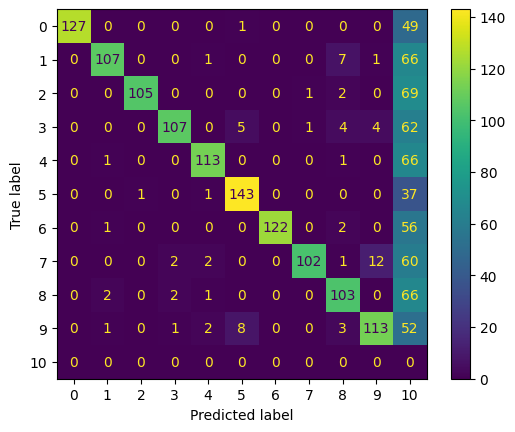

In [19]:
y_pred = result.copy()
y_pred = np.array(y_pred)
y_pred[y_pred == None] = 10
y_test = test[:,-1].tolist()
y_pred= y_pred.tolist()

cm = confusion_matrix(y_test, y_pred, labels=[0,1,2,3,4,5,6,7,8,9,10])
ConfusionMatrixDisplay(cm).plot()

Test de robustesse :

In [ ]:
def eps_accuracy(spn, eps1, eps2):
  '''
  On considère que les exemples pour lesquels notre classifieur hésite sont mal prédits.
  On obtient donc une accuracy décroissante lorsqu'on augmente epsilon.
  '''
  accuracies = []
  cspn = cspn_from_spn(spn, eps1)
  while eps1 < eps2:
    cspn = cspn_from_spn(spn, eps1)
    res = interval_dominance(cspn, test, [0,1,2,3,4,5,6,7,8,9])
    accuracies.append(accuracy(res))
    eps1 += 0.05
  return accuracies

In [ ]:
print(eps_accuracy(spn_classification, 0.1, 0.3))

/content/gdrive/My Drive/M2/MADI/Projet/Code/spn/structure/leaves/parametric/Inference.py:88: RuntimeWarning: divide by zero encountered in log
  probs[idx_in] = np.array(np.log(node.p))[cat_data[~out_domain_ids]]


[63.58574610244989, 63.58574610244989, 63.58574610244989, 63.58574610244989]


On constate que l'*accuracy* est la même pour $0.1 \leq \epsilon \leq 0.25$ : le classifieur n'est pas sensible à une variation d'$\epsilon$ à cette échelle.

In [73]:
def robustness(dict_eps, dataset, int_dom_array):
    '''
    Entrées : 
    - dict_eps : dict avec key = indice (int) dans le tableau int_dom_array, value = eps (float)
    - dataset : données à classifier (np.array)
    - int_dom_array : np.array avec chaque ligne correspondant un résultat  d'interval_dominance(cspn, dataset, classes) avec un epsilon différent
    Sortie : 
    - robustness : np.array : pour chaque valeur de dataset, le dernier epsilon pour lequel la classification était robuste
    '''
    m = np.shape(dataset)[0]
    robustness = np.ones(m)*(-1)
    for i in range(m):
        nb_eps = np.shape(int_dom_array)[0]
        for j in range(nb_eps):
            if int_dom_array[j,i] != None:
                robustness[i] = dict_eps[j]
            else:
                break
    return robustness

In [74]:
int_dom_array = np.concatenate((result_0001, result_005, result_01, result_1, result_5, result_8)).reshape((6, np.shape(result_0001)[0]))
dict_eps = {0:0.0001, 1:0.005, 2:0.01, 3:0.1, 4:0.5, 5:0.8}

In [75]:
res = list(robustness(dict_eps, test, int_dom_array))
print(res.count(-1))
print(res.count(0.0001))
print(res.count(0.005))
print(res.count(0.01))
print(res.count(0.1))
print(res.count(0.5))
print(res.count(0.8))

582
0
0
1
0
4
1209


Utilité selon la formule vue en cours :
\begin{equation}
    u(\hat{Y},y) = \left\{ \begin{array}{lll}
         0 & \mbox{si $y \notin \hat{Y}$}, \\
         \frac{\alpha}{|\hat{Y}|} - \frac{1-\alpha}{|\hat{Y}|^2} & \mbox{sinon},\end{array} \right.
\end{equation}
avec $u(\hat{Y},y) = 1$ si $|\hat{Y}| = 1$ et $\hat{Y} = y$.

In [ ]:
def utility(result, alpha):
  u = 0
  Y = len(result)
  for i in range(Y):
    if result[i] == test[i,-1]:
      u += (alpha/Y) - ((1-alpha)/Y**2)
  return u

utility(result, 1.6)

1.0175843621807643

In [ ]:
%matplotlib inline

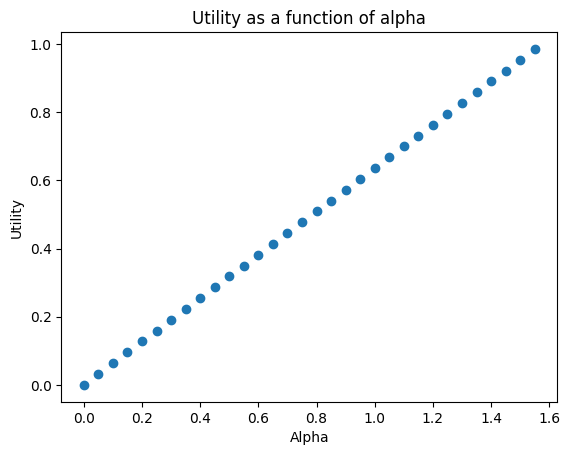

In [ ]:
def utility(result):
  u_list = [0]
  Y = len(result)
  alphas = [0]
  alpha = 0
  while u_list[-1] < 1:
    u = 0
    alpha += 0.05
    alphas.append(alpha)
    for i in range(Y):
      if result[i] == test[i,-1]:
        u += (alpha/Y) - ((1-alpha)/Y**2)
    u_list.append(u)
  fig, ax = plt.subplots()
  ax.scatter(alphas[:-1], u_list[:-1])
  ax.set_xlabel('Alpha')
  ax.set_ylabel('Utility')
  ax.set_title('Utility as a function of alpha')
  plt.show()

utility(result)